In [1]:
#IMPORTS
import firebase_admin
from firebase_admin import firestore
from firebase_admin import credentials
import pandas as pd


import numpy as np  
from scipy import stats  


In [2]:
cred = credentials.Certificate("./brazillian-gastronomic-tour-firebase-adminsdk-ojrgu-1c98d6e4b6.json")
app = firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
def collection_to_df(collection):
    items = list(db.collection(collection).stream())
    items_dict = list(map(lambda x: {'id': x.id, **x.to_dict()}, items))
    return pd.DataFrame(items_dict)
    

# Inicializando dataframes

In [4]:
#Inicializando Dataframes

users_df = collection_to_df("users")
users_df = users_df.rename(columns={"gameLevel": "currentGameLevel"})
users_df = users_df.rename(columns={"id": "user"})
users_df = users_df.set_index("user")

# Removendo usuários de teste.
users_df = users_df.drop(index = "GyaYyj1DPDQCFL8dtFJeLUbnqsr2").drop(index = "LrXx1XUUAfT05eBhi37WwrUF33e2")


user_level_df = collection_to_df("userLevel")

a_questions_df = collection_to_df("answeredQuestions")
a_questions_df['question'] = a_questions_df['question'].astype(int)
a_questions_df = a_questions_df.drop(columns=["correctAnswer", "id"])
questions_df = collection_to_df("questions")
questions_df = questions_df.rename(columns={"id": "question"})
questions_df['question'] = questions_df['question'].astype(int)

a_questions_df['lastUpdated']  = pd.to_datetime(a_questions_df.lastUpdated)
a_questions_df = questions_df.merge(a_questions_df, how="inner", on="question")
a_questions_df = a_questions_df.merge(users_df, how="inner", on="user")

a_questions_df = a_questions_df.sort_values("lastUpdated", ascending=True)

user_level_df = user_level_df.merge(users_df, how="inner", on="user")

users_df = users_df.drop(["name"], axis=1)
users_df

,ageRange,characterClass,levelProgress,userLevel,currentGameLevel,gender
user,,,,,,
1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Paladin,25.0,7,3,Male
2HZmPGWMIpbnJ5cBTr9ZixAfpHn1,13-25,Barbarian,0.0,1,1,Male
2oh7qd25jNSrFcLrxGlVtAl5hvk1,13-25,Wizard,87.5,7,3,Female
BJPHmgFSwpMSOkUVslu46yXK68U2,13-25,Barbarian,25.0,7,3,Male
EibAmAXfSbYmNUe2rL9LUTYFYtf1,13-25,Paladin,25.0,4,3,Male
K41XJMzIYeZa0edfemugBONdxj53,13-25,Wizard,25.0,7,3,Female
NDOJrSkLRcOkWgW1I6tq1PzvbRt1,26-55,Barbarian,25.0,7,3,Male
RLJsQiN2oZTGixYG7J2SRGqrJPg1,13-25,Barbarian,25.0,2,2,Male
Wzs4P9QkXNU4nH4K64IqBGf7E9g2,13-25,Barbarian,25.0,10,3,Male


# Notas
### Relação de notas dos jogadores por fase prática e de domínio

In [5]:

#user_nota

user_nota = a_questions_df.query("attemptNumber == 1").groupby(["user", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota = user_nota.pivot_table(index=["user","ageRange", "gender", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()


# 4 = coluna True
# 3 = coluna False



user_nota["nota"] = (user_nota.iloc[:,5] / (user_nota.iloc[:,5] + user_nota.iloc[:,4])) * 10


user_nota


correct,user,ageRange,gender,lagunasPhase,False,True,nota
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,domain,1,26,9.629630
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,practice,8,20,7.142857
2,2oh7qd25jNSrFcLrxGlVtAl5hvk1,13-25,Female,domain,9,18,6.666667
3,2oh7qd25jNSrFcLrxGlVtAl5hvk1,13-25,Female,practice,13,14,5.185185
4,BJPHmgFSwpMSOkUVslu46yXK68U2,13-25,Male,domain,0,28,10.000000
5,BJPHmgFSwpMSOkUVslu46yXK68U2,13-25,Male,practice,7,20,7.407407
6,EibAmAXfSbYmNUe2rL9LUTYFYtf1,13-25,Male,domain,1,19,9.500000
7,EibAmAXfSbYmNUe2rL9LUTYFYtf1,13-25,Male,practice,7,13,6.500000
8,K41XJMzIYeZa0edfemugBONdxj53,13-25,Female,domain,1,26,9.629630
9,K41XJMzIYeZa0edfemugBONdxj53,13-25,Female,practice,5,22,8.148148


### Relação de notas dos jogadores por fase prática e de domínio e level

In [6]:
#user_nota_level

user_nota_level = a_questions_df.query("attemptNumber == 1").groupby(["user", "level", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota_level = user_nota_level.pivot_table(index=["user", "ageRange", "gender", "level", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

user_nota_level["nota"] = (user_nota_level.iloc[:,6] / (user_nota_level.iloc[:,6] + user_nota_level.iloc[:,5])) * 10

user_nota_level



correct,user,ageRange,gender,level,lagunasPhase,False,True,nota
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,1,domain,1,9,9.000000
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,1,practice,2,8,8.000000
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,2,domain,0,10,10.000000
3,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,2,practice,3,7,7.000000
4,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,Male,3,domain,0,7,10.000000
...,...,...,...,...,...,...,...,...
67,y13rfxpEhzcVDASZFjAHKjT3jzh1,13-25,Female,1,practice,4,7,6.363636
68,y13rfxpEhzcVDASZFjAHKjT3jzh1,13-25,Female,2,domain,0,10,10.000000
69,y13rfxpEhzcVDASZFjAHKjT3jzh1,13-25,Female,2,practice,4,6,6.000000
70,y13rfxpEhzcVDASZFjAHKjT3jzh1,13-25,Female,3,domain,0,7,10.000000


### Média de nota por idade

#### Fase Prática

<Axes: title={'center': 'Notas por faixa etária: Prática'}, xlabel='Faixa Etária', ylabel='Média'>

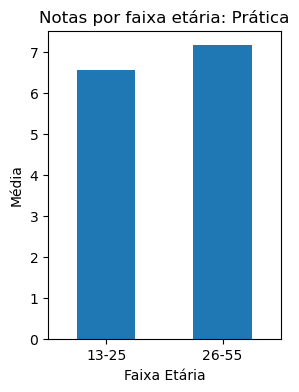

In [7]:
user_nota_level_average_age_range_practice = user_nota_level.query("lagunasPhase == 'practice'").groupby(["ageRange"])["nota"].mean()

user_nota_level_average_age_range_practice.plot.bar(figsize=(3,4),  rot=0, title='Notas por faixa etária: Prática', xlabel='Faixa Etária', ylabel='Média')


#### Fase Domínio

<Axes: title={'center': 'Notas por faixa etária: Domínio'}, xlabel='Faixa Etária', ylabel='Nota'>

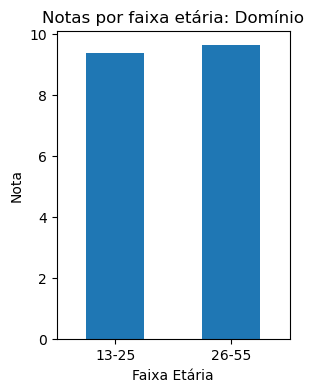

In [8]:
user_nota_level_average_age_range_domain = user_nota_level.query("lagunasPhase == 'domain'").groupby(["ageRange"])["nota"].mean()

user_nota_level_average_age_range_domain.plot.bar(figsize=(3,4), rot=0, title='Notas por faixa etária: Domínio', xlabel='Faixa Etária', ylabel='Nota')

### Média de nota por lagunasPhase

<Axes: title={'center': 'Notas por fase'}, xlabel='Fase', ylabel='Nota'>

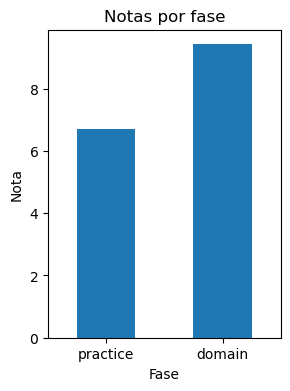

In [9]:
user_nota_level_average_lagunas = user_nota_level.groupby(["lagunasPhase"])["nota"].mean().sort_values(ascending=True)

user_nota_level_average_lagunas.plot.bar(figsize=(3,4), rot=0, title='Notas por fase', xlabel='Fase', ylabel='Nota')



### Média de nota por sexo

#### Fase Prática

<Axes: title={'center': 'Notas por gênero: Prática'}, xlabel='Gênero', ylabel='Nota'>

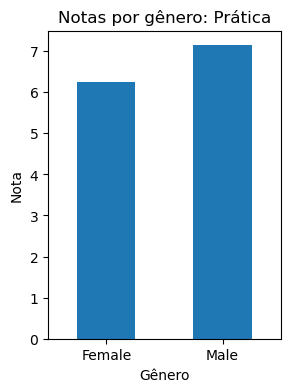

In [10]:
user_nota_level_average_gender_practice = user_nota_level.query("lagunasPhase == 'practice'").groupby(["gender"])["nota"].mean()

user_nota_level_average_gender_practice.plot.bar(figsize=(3,4), rot=0, title='Notas por gênero: Prática', xlabel='Gênero', ylabel='Nota')

#### Fase de Domínio

<Axes: title={'center': 'Notas por gênero: Domínio'}, xlabel='Gênero', ylabel='Nota'>

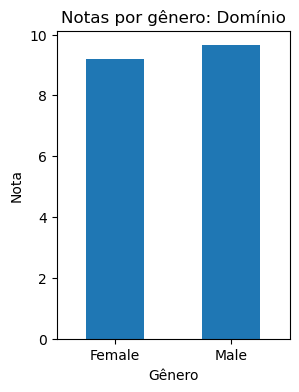

In [11]:
user_nota_level_average_gender_domain = user_nota_level.query("lagunasPhase == 'domain'").groupby(["gender"])["nota"].mean()

user_nota_level_average_gender_domain.plot.bar(figsize=(3,4), rot=0, title='Notas por gênero: Domínio', xlabel='Gênero', ylabel='Nota')

# Relação de acerto e erro

### Acerto e erro por nível

In [12]:
#acerto_erro_by_nivel

acerto_erro_by_nivel = a_questions_df.query("attemptNumber == 1").groupby(["level", "correct"], as_index=False).agg({'question': 'count'})

acerto_erro_by_nivel['percent'] =  acerto_erro_by_nivel['question'] / acerto_erro_by_nivel.groupby(['level'])['question'].transform('sum') * 100
acerto_erro_by_nivel

,level,correct,question,percent
0,1,False,69,21.495327
1,1,True,252,78.504673
2,2,False,36,16.363636
3,2,True,184,83.636364
4,3,False,25,19.531250
5,3,True,103,80.468750


### Acerto e erro por fase prática e de domínio

In [13]:
#acerto_erro_by_phase

acerto_erro_by_phase = a_questions_df.query("attemptNumber == 1").groupby(["lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase['percent'] =  acerto_erro_by_phase['question'] / acerto_erro_by_phase.groupby(['lagunasPhase'])['question'].transform('sum') * 100
acerto_erro_by_phase

,lagunasPhase,correct,question,percent
0,domain,False,20,5.988024
1,domain,True,314,94.011976
2,practice,False,110,32.835821
3,practice,True,225,67.164179


### Acerto e erro por fase e nível

In [14]:
#Taxa de acerto e erro por nível e mostrando a fase laguna

acerto_erro_by_phase_level = a_questions_df.query("attemptNumber == 1").groupby(["level", "lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase_level['percent'] =  acerto_erro_by_phase_level['question'] / acerto_erro_by_phase_level.groupby(['level', 'lagunasPhase'])['question'].transform('sum') * 100
acerto_erro_by_phase_level

,level,lagunasPhase,correct,question,percent
0,1,domain,False,15,9.375000
1,1,domain,True,145,90.625000
2,1,practice,False,54,33.540373
3,1,practice,True,107,66.459627
4,2,domain,False,3,2.727273
5,2,domain,True,107,97.272727
6,2,practice,False,33,30.000000
7,2,practice,True,77,70.000000
8,3,domain,False,2,3.125000
9,3,domain,True,62,96.875000


### Acerto e erro por faixa etária

In [15]:
acerto_erro_by_age_range = a_questions_df.query("attemptNumber == 1").groupby(["ageRange", "correct"], as_index=False).agg({'question': 'count'})
acerto_erro_by_age_range


,ageRange,correct,question
0,13-25,False,103
1,13-25,True,397
2,26-55,False,27
3,26-55,True,142


### Acerto e erro por gênero

In [16]:
acerto_erro_by_gender = a_questions_df.query("attemptNumber == 1").groupby(["gender", "correct"], as_index=False).agg({'question': 'count'})
acerto_erro_by_gender

,gender,correct,question
0,Female,False,75
1,Female,True,256
2,Male,False,55
3,Male,True,283


# Porcentagem de acerto e erro por questão

In [17]:
#questions_percentage

questions_percentage = a_questions_df.query("attemptNumber == 1").groupby(["question", "correct"], as_index=False)["text"].count().rename(columns={"text": "count"})


questions_percentage = questions_percentage.pivot_table(index=["question"], 
                    columns=["correct"], 
                    values='count',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

questions_percentage.rename(columns={ questions_percentage.columns[2]: "corretas" }, inplace = True)
questions_percentage.rename(columns={ questions_percentage.columns[1]: "erradas" }, inplace = True)


questions_percentage["% corretas"] = (questions_percentage["corretas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["% erradas"] = (questions_percentage["erradas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["total de perguntas"] = questions_percentage["erradas"]  + questions_percentage["corretas"] 

questions_percentage

correct,question,erradas,corretas,% corretas,% erradas,total de perguntas
0,2,4,28,87.500000,12.500000,32
1,3,8,24,75.000000,25.000000,32
2,4,2,30,93.750000,6.250000,32
3,5,9,23,71.875000,28.125000,32
4,6,13,19,59.375000,40.625000,32
5,7,10,22,68.750000,31.250000,32
6,8,4,28,87.500000,12.500000,32
7,9,11,22,66.666667,33.333333,33
8,10,2,30,93.750000,6.250000,32
9,11,6,26,81.250000,18.750000,32


# Classificação de perfis de acordo com a metodologia Serrano-Laguna

In [18]:
#Definição de perfis laguna
#LI = 7
#LF = 7


it = 7
ft = 7
# FA >= FT ==> 
def classifier(row):
    if row["domain"] >= ft:
            if row["practice"] < it:
                  return "Aprendiz"
            else:
                  return "Mestre"
    else:
            if row["practice"] < it:
                  return "Não-Aprendiz"
            else:
                  return "Deslocado"

user_nota_classification = user_nota.pivot(index=["user", "ageRange"], columns=["lagunasPhase"], values="nota")
user_nota_classification["classification"] = user_nota_classification.apply(classifier, axis=1)

user_nota_classification


,lagunasPhase,domain,practice,classification
user,ageRange,,,
1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,26-55,9.629630,7.142857,Mestre
2oh7qd25jNSrFcLrxGlVtAl5hvk1,13-25,6.666667,5.185185,Não-Aprendiz
BJPHmgFSwpMSOkUVslu46yXK68U2,13-25,10.000000,7.407407,Mestre
EibAmAXfSbYmNUe2rL9LUTYFYtf1,13-25,9.500000,6.500000,Aprendiz
K41XJMzIYeZa0edfemugBONdxj53,13-25,9.629630,8.148148,Mestre
NDOJrSkLRcOkWgW1I6tq1PzvbRt1,26-55,9.629630,7.037037,Mestre
RLJsQiN2oZTGixYG7J2SRGqrJPg1,13-25,9.000000,6.000000,Aprendiz
Wzs4P9QkXNU4nH4K64IqBGf7E9g2,13-25,9.259259,8.148148,Mestre
a1meF6EP2MWNWbd4LiW4djGVArq2,13-25,9.629630,5.925926,Aprendiz


### Gráfico com a clasificação geral

<Axes: title={'center': 'Classificação geral em porcentagem'}>

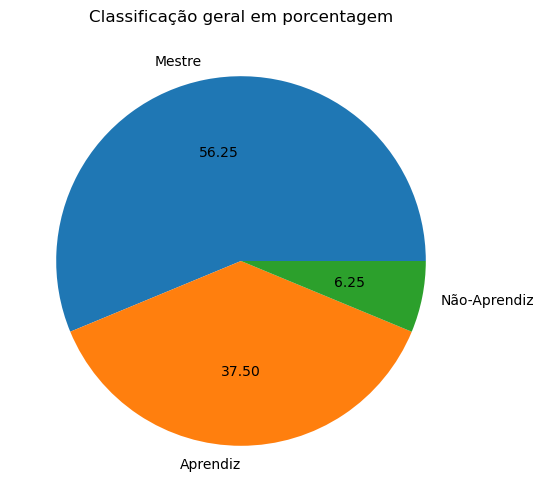

In [19]:
#Plot Grafico
user_nota_classification["classification"].value_counts().plot.pie(figsize=(6, 6), autopct="%.2f", title='Classificação geral em porcentagem', ylabel='')

In [20]:
#user_nota_classification_level

user_nota_classification_level = user_nota_level.pivot(index=["user", "level"], columns="lagunasPhase", values="nota").reset_index()
user_nota_classification_level["classification"] =  user_nota_classification_level.apply(classifier, axis=1)
user_nota_classification_level

lagunasPhase,user,level,domain,practice,classification
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,9.000000,8.000000,Mestre
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,10.000000,7.000000,Mestre
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,3,10.000000,6.250000,Aprendiz
3,2oh7qd25jNSrFcLrxGlVtAl5hvk1,1,4.000000,3.000000,Não-Aprendiz
4,2oh7qd25jNSrFcLrxGlVtAl5hvk1,2,8.000000,7.000000,Mestre
5,2oh7qd25jNSrFcLrxGlVtAl5hvk1,3,8.571429,5.714286,Aprendiz
6,BJPHmgFSwpMSOkUVslu46yXK68U2,1,10.000000,6.000000,Aprendiz
7,BJPHmgFSwpMSOkUVslu46yXK68U2,2,10.000000,8.000000,Mestre
8,BJPHmgFSwpMSOkUVslu46yXK68U2,3,10.000000,8.571429,Mestre
9,EibAmAXfSbYmNUe2rL9LUTYFYtf1,1,10.000000,5.000000,Aprendiz


### Gráfico com a clasificação por nível

In [21]:
#user_nota_classification_level_reshaped

user_nota_classification_level_reshaped = user_nota_classification_level.drop(["domain", "practice"], axis=1)

user_nota_classification_level_reshaped = user_nota_classification_level_reshaped.groupby(["level", "classification"]).count().reset_index()

user_nota_classification_level_reshaped = pd.pivot_table(user_nota_classification_level_reshaped, index = "classification", columns="level", values="user", fill_value=0)

user_nota_classification_level_reshaped



level,1,2,3
classification,,,
Aprendiz,7,3,5
Mestre,8,8,4
Não-Aprendiz,1,0,0


array([<Axes: ylabel='1'>, <Axes: ylabel='2'>, <Axes: ylabel='3'>],
      dtype=object)

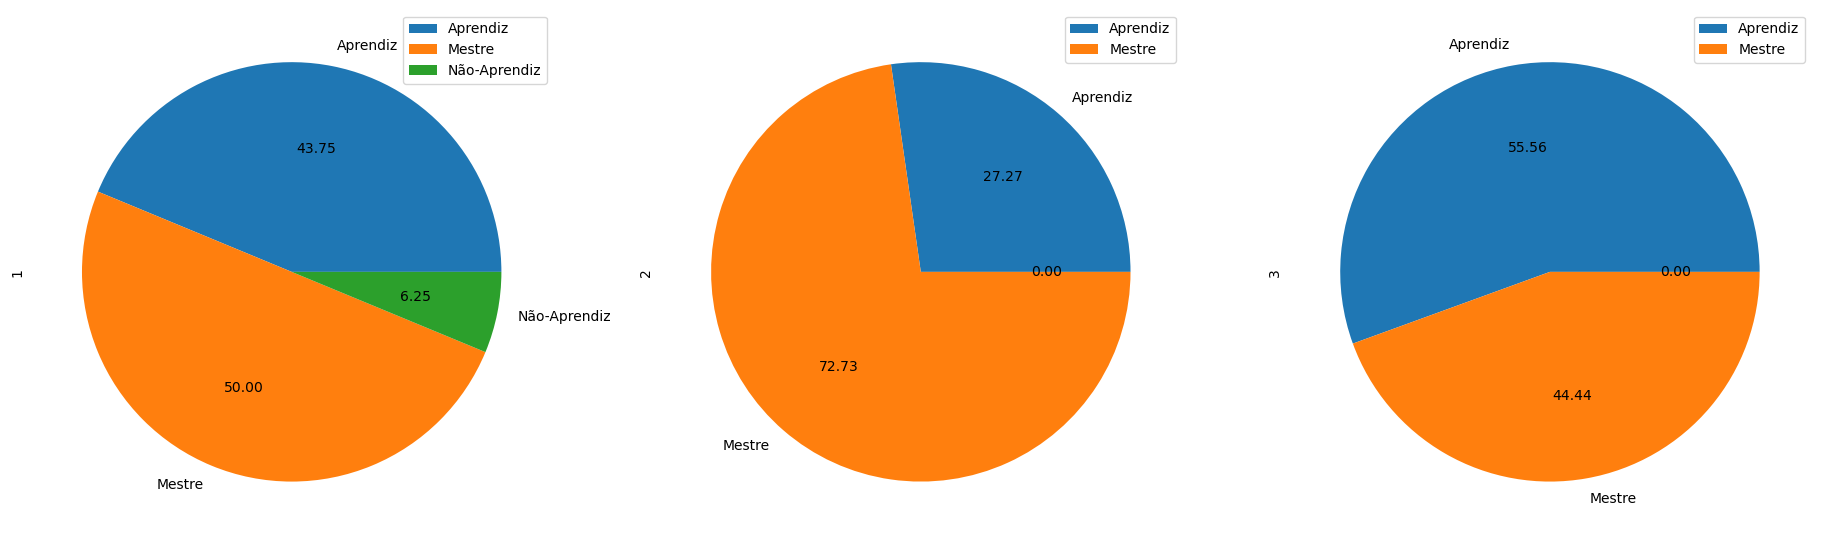

In [22]:
#Plot Grafico

user_nota_classification_level_reshaped.plot.pie(subplots=True, figsize=(23, 20), autopct="%.2f")

### Gráfico com a classificação por faixa etária

In [23]:
user_nota_classification_age_range = user_nota.pivot(index=["user",  "ageRange"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_age_range["classification"] =  user_nota_classification_age_range.apply(classifier, axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.drop(["domain", "practice"], axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.groupby(["ageRange", "classification"]).count().reset_index()

user_nota_classification_age_range = pd.pivot_table(user_nota_classification_age_range, index = "classification", columns="ageRange", values="user", fill_value=0)
user_nota_classification_age_range



ageRange,13-25,26-55
classification,,
Aprendiz,6,0
Mestre,5,4
Não-Aprendiz,1,0


array([<Axes: ylabel='13-25'>, <Axes: ylabel='26-55'>], dtype=object)

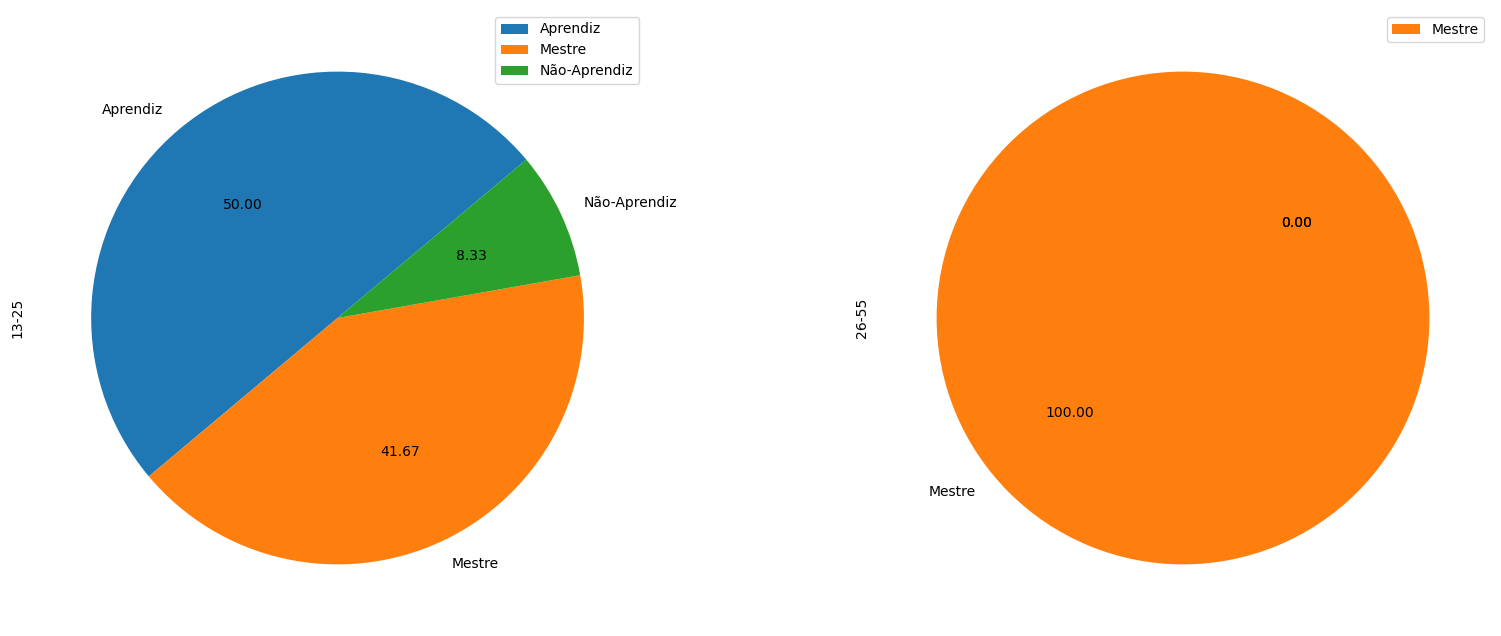

In [24]:

user_nota_classification_age_range.plot.pie(subplots=True,figsize=(20, 8), autopct="%.2f", startangle=40)

### Relação por gênero

In [25]:
user_nota_classification_gender = user_nota.pivot(index=["user",  "gender"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_gender["classification"] =  user_nota_classification_gender.apply(classifier, axis=1)
user_nota_classification_gender = user_nota_classification_gender.drop(["domain", "practice"], axis=1)
user_nota_classification_gender = user_nota_classification_gender.groupby(["gender", "classification"]).count().reset_index()

user_nota_classification_gender = pd.pivot_table(user_nota_classification_gender, index = "classification", columns="gender", values="user", fill_value=0)
user_nota_classification_gender

gender,Female,Male
classification,,
Aprendiz,3,3
Mestre,3,6
Não-Aprendiz,1,0


### Relação de classificação no sexo Feminino

<Axes: title={'center': 'Classificação geral: Sexo feminino'}>

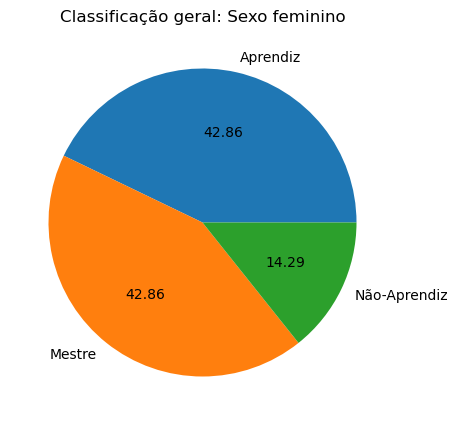

In [26]:
user_nota_classification_gender["Female"].plot.pie(figsize=(5, 5), autopct="%.2f", title="Classificação geral: Sexo feminino", ylabel="")

### Relação de classificação no sexo Masculino

<Axes: title={'center': 'Classificação geral: Sexo masculino'}>

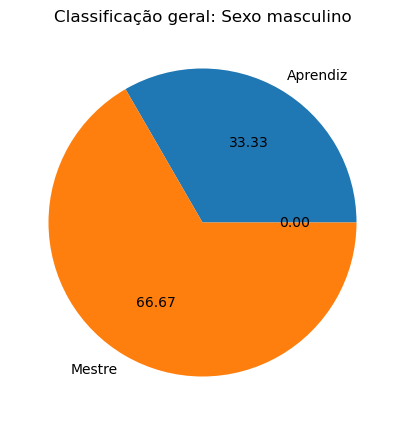

In [27]:
user_nota_classification_gender["Male"].plot.pie(figsize=(5, 5), autopct="%.2f", title="Classificação geral: Sexo masculino", ylabel="")

# Relação de tempo entre perguntas

In [28]:
a_questions_df["averageSecondsBwQuestions"] = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])['lastUpdated'].diff().dt.seconds


### Relação de tempo entre perguntas por nível e fase (prática/domínio)

In [29]:
a_questions_df_average_time_level = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
a_questions_df_average_time_level

,user,level,lagunasPhase,averageSecondsBwQuestions
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,domain,10.444444
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,practice,23.333333
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,domain,11.666667
3,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,practice,19.000000
4,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,3,domain,16.166667
...,...,...,...,...
67,y13rfxpEhzcVDASZFjAHKjT3jzh1,1,practice,26.500000
68,y13rfxpEhzcVDASZFjAHKjT3jzh1,2,domain,5.777778
69,y13rfxpEhzcVDASZFjAHKjT3jzh1,2,practice,8.555556
70,y13rfxpEhzcVDASZFjAHKjT3jzh1,3,domain,5.833333


lagunasPhase,domain,practice
level,,
1,15.249635,47.133224
2,10.535354,31.333333
3,12.038869,18.221205


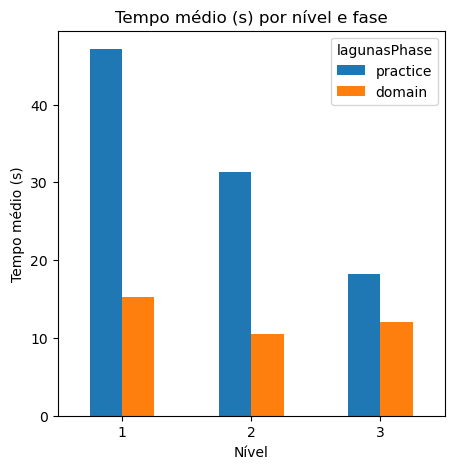

In [30]:
a_questions_df_average_time_level_general = pd.pivot_table(a_questions_df_average_time_level, index = "level", columns="lagunasPhase", values="averageSecondsBwQuestions", aggfunc="mean")
a_questions_df_average_time_level_general.plot.bar(figsize=(5, 5), rot=0, title = "Tempo médio (s) por nível e fase", xlabel="Nível", ylabel="Tempo médio (s)", y=["practice", "domain"])
a_questions_df_average_time_level_general


### Média de tempo entre perguntas por fase (prática/domínio)

In [31]:
a_questions_df_average_time = a_questions_df_average_time_level.groupby(['user', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
a_questions_df_average_time

,user,lagunasPhase,averageSecondsBwQuestions
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,domain,12.759259
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,practice,23.206349
2,2oh7qd25jNSrFcLrxGlVtAl5hvk1,domain,27.998051
3,2oh7qd25jNSrFcLrxGlVtAl5hvk1,practice,54.562378
4,BJPHmgFSwpMSOkUVslu46yXK68U2,domain,8.169312
5,BJPHmgFSwpMSOkUVslu46yXK68U2,practice,17.462963
6,EibAmAXfSbYmNUe2rL9LUTYFYtf1,domain,11.777778
7,EibAmAXfSbYmNUe2rL9LUTYFYtf1,practice,21.055556
8,K41XJMzIYeZa0edfemugBONdxj53,domain,12.388889
9,K41XJMzIYeZa0edfemugBONdxj53,practice,20.685185


<Axes: title={'center': 'Tempo médio (s) por fase'}, xlabel='Fase', ylabel='Tempo médio (s)'>

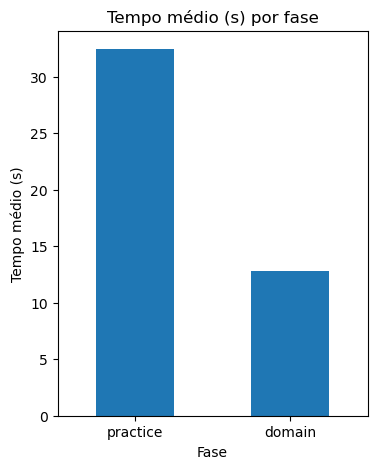

In [32]:
a_questions_df_average_time_general = a_questions_df_average_time.groupby("lagunasPhase")["averageSecondsBwQuestions"].mean().sort_values(ascending=False)
a_questions_df_average_time_general.plot.bar(figsize=(4, 5), rot=0, title="Tempo médio (s) por fase", xlabel="Fase", ylabel="Tempo médio (s)")


# Teste de hipóteses: Gênero


### Fase prática: Verificar se existe diferenças significativas nas médias entre os sexos F e M
### Hipótese nula: não existem diferenças significativas nas médias dos sexos F e M
### Hipótese alternativa: Existem diferenças significativas nas médias dos sexos F e M  

In [33]:
user_nota_practice = user_nota.query("lagunasPhase == 'practice'")
nota_practice_male = user_nota_practice.query("gender == 'Male'")["nota"]
nota_practice_female = user_nota_practice.query("gender == 'Female'")["nota"]

print("Seguem uma distribuição normal: foi utilizado o teste shapiro pois o tamanho da amostra é menor que 50")
print("Masculino: Shapiro p > 0.05", stats.shapiro(nota_practice_male))
print("Feminino: Shapiro p > 0.05", stats.shapiro(nota_practice_female))

print("\nVariâncias são homogêneas: ")
print("Levene p > 0.05: ")
print(stats.levene(nota_practice_male, nota_practice_female))

print("\nAceitamos a hipótese nula, ou seja, não houveram diferenças significativas baseadas no sexo para a fase prática")
print("T teste, p > 0.05")
print(stats.ttest_ind(a=nota_practice_male, b=nota_practice_female, equal_var=True))

# pvalue=0.4680149035065640
# Significa que não houve diferenças significativas baseadas no sexo para a fase prática


Seguem uma distribuição normal: foi utilizado o teste shapiro pois o tamanho da amostra é menor que 50
Masculino: Shapiro p > 0.05 ShapiroResult(statistic=0.944467306137085, pvalue=0.6296290159225464)
Feminino: Shapiro p > 0.05 ShapiroResult(statistic=0.8846020102500916, pvalue=0.24767175316810608)

Variâncias são homogêneas: 
Levene p > 0.05: 
LeveneResult(statistic=0.632522687679007, pvalue=0.4397078504920269)

Aceitamos a hipótese nula, ou seja, não houveram diferenças significativas baseadas no sexo para a fase prática
T teste, p > 0.05
TtestResult(statistic=0.7459906673292875, pvalue=0.46801490350656405, df=14.0)


### Fase de domínio: Verificar se existe diferenças significativas nas médias entre os sexos F e M

In [34]:
user_nota_domain = user_nota.query("lagunasPhase == 'domain'")
nota_domain_male = user_nota_practice.query("gender == 'Male'")["nota"]
nota_domain_female = user_nota_practice.query("gender == 'Female'")["nota"]

print("Seguem uma distribuição normal: foi utilizado o teste shapiro pois o tamanho da amostra é menor que 50")

print("Masculino: Shapiro p > 0.05", stats.shapiro(nota_domain_male))
print("Feminino: Shapiro p > 0.05", stats.shapiro(nota_domain_female))

print("\nVariâncias são homogêneas: ")
print("Levene p > 0.05: ")
print(stats.levene(nota_domain_male, nota_domain_female))

print("\nAceitamos a hipótese nula, ou seja, não houveram diferenças significativas baseadas no sexo para a fase de domínio")
print("T teste, p > 0.05")
print(stats.ttest_ind(a=nota_domain_male, b=nota_domain_female, equal_var=True))

# pvalue=0.4680149035065640
# Significa que não houve diferenças significativas baseadas no sexo para a fase prática

Seguem uma distribuição normal: foi utilizado o teste shapiro pois o tamanho da amostra é menor que 50
Masculino: Shapiro p > 0.05 ShapiroResult(statistic=0.944467306137085, pvalue=0.6296290159225464)
Feminino: Shapiro p > 0.05 ShapiroResult(statistic=0.8846020102500916, pvalue=0.24767175316810608)

Variâncias são homogêneas: 
Levene p > 0.05: 
LeveneResult(statistic=0.632522687679007, pvalue=0.4397078504920269)

Aceitamos a hipótese nula, ou seja, não houveram diferenças significativas baseadas no sexo para a fase de domínio
T teste, p > 0.05
TtestResult(statistic=0.7459906673292875, pvalue=0.46801490350656405, df=14.0)
